In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
# Display all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# settings to display all columns
pd.set_option("display.max_columns", None)

In [3]:
random.seed(42)

# Data load

In [4]:
df = pd.read_csv('_data/homepage_actions.csv')
df.head()

,timestamp,id,group,action
0,2016-09-24 17:42:27.839496,804196,experiment,view
1,2016-09-24 19:19:03.542569,434745,experiment,view
2,2016-09-24 19:36:00.944135,507599,experiment,view
3,2016-09-24 19:59:02.646620,671993,control,view
4,2016-09-24 20:26:14.466886,536734,experiment,view


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8188 entries, 0 to 8187
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  8188 non-null   object
 1   id         8188 non-null   int64 
 2   group      8188 non-null   object
 3   action     8188 non-null   object
dtypes: int64(1), object(3)
memory usage: 256.0+ KB


In [6]:
len(df[df['group'] == 'control']['id'])

4264

In [7]:
len(df[df['group'] == 'experiment']['id'])

3924

In [8]:
df.action.value_counts()

view     6328
click    1860
Name: action, dtype: int64

In [9]:
df.id.nunique()

6328

In [10]:
df[df.id.duplicated(keep = False)].sort_values('id')

,timestamp,id,group,action
5639,2016-12-14 13:19:00.940677,182994,control,view
5640,2016-12-14 13:20:29.564080,182994,control,click
3941,2016-11-20 08:00:22.434253,183141,experiment,click
3940,2016-11-20 07:58:52.768641,183141,experiment,view
4247,2016-11-24 02:31:00.749999,183248,control,click
...,...,...,...,...
7744,2017-01-12 05:09:57.355933,935742,experiment,view
5254,2016-12-09 07:05:04.965876,937139,experiment,view
5255,2016-12-09 07:06:05.219267,937139,experiment,click
3494,2016-11-14 08:01:25.774204,937217,control,click


With the visual inspection of the above output and this calculation, 3720 records = 1860 clicks + 1860 views, I can guess how the data were collected -- if a user  viewed and did not click, there is only one record under this user's ID; if a user viewed and clicked, two records, one 'view' and one 'click'.

I calcuated a CTR of each group as below.

In [11]:
ctl_df = df.query('group == "control"')
exp_df = df.query('group == "experiment"')

ctl_ctr = ctl_df.query('action == "click"').id.nunique() / ctl_df.query('action == "view"').id.nunique()
exp_ctr = exp_df.query('action == "click"').id.nunique() / exp_df.query('action == "view"').id.nunique()

ctl_ctr
exp_ctr

0.2797118847539016

0.3097463284379172

# Data wrangling

I will make two arrays for each group, containing True if a user ever clicked, and False if a user never clicked.

In [12]:
ctl_df = df.query('group == "control"')
ctl_df = ctl_df.sort_values(by = ['id', 'action'])
ctl_df = ctl_df.drop_duplicates(subset = ['id'], keep = 'first')

ctl_df = ctl_df.drop(['timestamp', 'id'], axis=1)

In [13]:
ctl_df.loc[ctl_df['action'] == 'view', 'clicked'] = False
ctl_df.loc[ctl_df['action'] == 'click', 'clicked'] = True

In [14]:
ctl_df = ctl_df.drop(['action'], axis=1)

In [15]:
ctl_df

,group,clicked
5640,control,True
376,control,False
4247,control,True
2746,control,False
651,control,False
...,...,...
5076,control,False
593,control,False
6081,control,False
7389,control,False


In [16]:
exp_df = df.query('group == "experiment"')
exp_df = exp_df.sort_values(by = ['id', 'action'])
exp_df = exp_df.drop_duplicates(subset = ['id'], keep = 'first')

exp_df = exp_df.drop(['timestamp', 'id'], axis=1)

exp_df.loc[exp_df['action'] == 'view', 'clicked'] = False
exp_df.loc[exp_df['action'] == 'click', 'clicked'] = True

exp_df = exp_df.drop(['action'], axis=1)

In [17]:
both_df = pd.concat([ctl_df, exp_df])
both_df

,group,clicked
5640,control,True
376,control,False
4247,control,True
2746,control,False
651,control,False
...,...,...
5157,experiment,False
4490,experiment,False
7745,experiment,True
942,experiment,False


In [18]:
n_exp = len(exp_df)
n_ctl = len(ctl_df)

In [19]:
ctl_ctr = np.sum(ctl_df['clicked']) / len(ctl_df)
exp_ctr = np.sum(exp_df['clicked']) / len(exp_df)
ctl_ctr
exp_ctr

0.2797118847539016

0.3097463284379172

In [20]:
obs_diff = exp_ctr - ctl_ctr
obs_diff

0.030034443684015644

Next, I test the below **hypothesis**:

$$H_0: p_{exp} - p_{ctl} \leq 0$$
$$H_1: p_{exp} - p_{ctl} > 0$$

I wll use 4 different methods:
* Parametric method
* Permutation sampling
* Bootstrapping
* Use of an existing model

# Parametric Method

In [21]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [22]:
successes = [928, 932]
nobs = [n_exp, n_ctl]

z_stat, pval = proportions_ztest(successes, nobs=nobs, alternative = 'larger')
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.5f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for experiment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 2.62
p-value: 0.00442
ci 95% for control group: [0.293, 0.326]
ci 95% for experiment group: [0.264, 0.295]


# Permutation

In [23]:
ctl = ctl_df['clicked'].values
exp = exp_df['clicked'].values

In [24]:
diffs_pm = np.empty(10000)

for i in range(10000):
    # Concatenate the data sets: data
    data = np.concatenate((ctl, exp))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    ctl_perm_sample = permuted_data[:len(ctl)]
    exp_perm_sample = permuted_data[len(exp):]
    
    diff_sample = np.sum(exp_perm_sample) / len(exp_perm_sample) - \
                np.sum(ctl_perm_sample) / len(ctl_perm_sample)
    
    # Compute the test statistic
    diffs_pm[i] = diff_sample

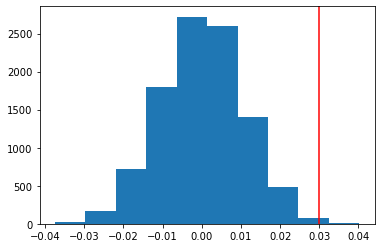

In [25]:
plt.hist(diffs_pm)
plt.axvline(x = obs_diff, color='r');

In [26]:
# Compute and print p-value: p
# Portion of differences that are larger than the observed difference
p = np.sum(diffs_pm > obs_diff) / len(diffs_pm)
print('p-value =', p)

p-value = 0.0026


# Bootstrapping

A/B testing project in Udacity Data Analytics Nanodegree

In [27]:
# 1) Compute the observed difference
obs_diff = exp_ctr - ctl_ctr

In [28]:
# 2) Simulate the sampling distribution for the difference in proportions
diffs_bt = []

for _ in range(10000):
    # Pick from the whole data with replacement
    b_samp = both_df.sample(both_df.shape[0], replace = True)
    
    ctl_samp = b_samp.query('group == "control"')
    exp_samp = b_samp.query('group == "experiment"')
    
    ctl_samp_ctr = ctl_samp['clicked'].sum() / len(ctl_samp)
    exp_samp_ctr = exp_samp['clicked'].sum() / len(exp_samp)
 
    diffs_bt.append(exp_samp_ctr - ctl_samp_ctr)

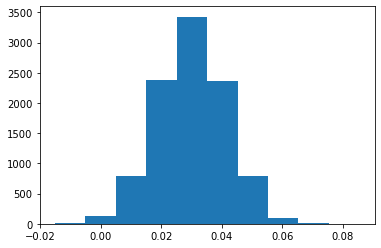

In [29]:
plt.hist(diffs_bt);

In [30]:
# 3) Use the above sampling distribution 
# to simulate the distribution under the null hypothesis, 
# by creating a random normal distribution centered at 0, with the same spread and size
diffs_arr = np.array(diffs_bt)
null_vals = np.random.normal(0, diffs_arr.std(), diffs_arr.size)

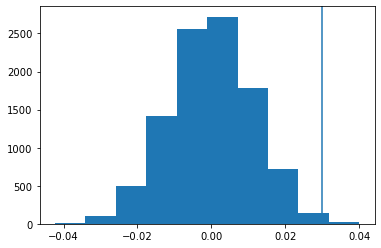

In [31]:
plt.hist(null_vals)
plt.axvline(x = obs_diff);

In [32]:
# 4) Compute the p-value by finding the proportion of values in the null distribution 
# that were greater than our observed difference.
p = (null_vals > obs_diff).mean()
print('p-value =', p)

p-value = 0.0032


Use this p-value to determine the statistical significance of our observed difference.

# Use an existing distribution

Simulate using a binomial distribution

In [33]:
p_null = np.sum(both_df['clicked']) / len(both_df)
p_null

0.2939317319848293

## Use np.random.choice()

In [34]:
diffs_bd_1 = []

for _ in range(10000):
    new_page_converted = np.random.choice([1,0], size = n_exp, replace = True, p = (p_null, 1-p_null))
    old_page_converted = np.random.choice([1,0], size = n_ctl, replace = True, p = (p_null, 1-p_null))

    diffs_bd_1.append(new_page_converted.mean() - old_page_converted.mean())

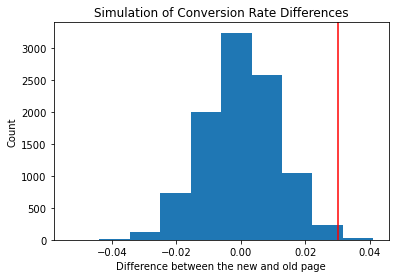

In [35]:
plt.hist(diffs_bd_1)
plt.title('Simulation of Conversion Rate Differences')
plt.xlabel('Difference between the new and old page')
plt.ylabel('Count')

plt.axvline(x = obs_diff, color='r');

In [36]:
count = 0
for i in diffs_bd_1:
    if i > obs_diff:
        count = count+1
        
p = count/len(diffs_bd_1)
print('p-value =', p)

p-value = 0.0051


## Use np.random.binomial()

In [37]:
new_simulation = np.random.binomial(n_exp, p_null, 10000)/n_exp
old_simulation = np.random.binomial(n_ctl, p_null, 10000)/n_ctl
diffs_bd_2 = new_simulation - old_simulation

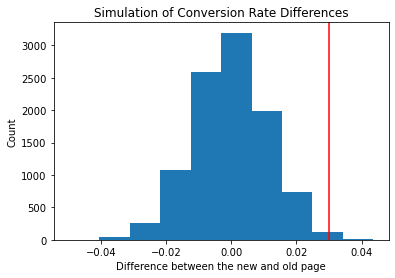

In [38]:
plt.hist(diffs_bd_2)
plt.title('Simulation of Conversion Rate Differences')
plt.xlabel('Difference between the new and old page')
plt.ylabel('Count')

plt.axvline(x=obs_diff, color='r');

In [39]:
count = 0
for i in diffs_bd_2:
    if i > obs_diff:
        count = count+1
        
p = count/len(diffs_bd_2)
print('p-value =', p)

p-value = 0.004
